# Manipulate MPS Recorded Crime to Annual Major Categories for LSOAs

Part of [london-data](https://github.com/jamesdamillington/london-data), by [jamesdamillington](https://github.com/jamesdamillington)

## Aim
Summarise [Metropolitan Police Service Recorded Crime data](https://data.london.gov.uk/dataset/recorded_crime_summary) to annual totals per LSOA for the 11 major crime categories:
1. Arson and Criminal Damage
2. Burglary
3. Drug Offences
4. Miscellaneous Crimes Against Society
5. Possession of Weapons
6. Public Order Offences
7. Robbery
8. Sexual Offences
9. Theft
10. Vehicle Offences
11. Violence Against the Person

Also for two minor categories:
- Bicycle Theft
- Theft or Taking of a Motor Vehicle

Input data are monthly counts from April 2010. Use complete years only 2011-2021. Outputs will be a `.csv` per crime catgory that can be readily joined to [ONS Geographies data](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census). NB: MPS does not include data for the City of London, so six LSOAs are 'missing'. 

In [1]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-08-26


In [2]:
import pyproj
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from pathlib import Path

## Get Geography

Read [London 2011 LSOA census geography](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census) for filtering Great Britain data to London only.
> Source: Office for National Statistics licensed under the [Open Government Licence v.3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/)  
Contains OS data © Crown copyright and database right (2022)

In [3]:
census_path = Path("../data/geographies/census/")
london = gpd.read_file(census_path/"london-2011-lsoa.shp")
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 264.5+ KB


## Read, Summarise

Original data downloaded [2022-08-26]:
- [MPS LSOA Level Crime (historic)](https://data.london.gov.uk/download/recorded_crime_summary/9bb3efe6-98fb-47c1-af3e-3be721e8a1cd/MPS%20LSOA%20Level%20Crime%20%28Historical%29.csv) 
- [MPS LSOA Level Crime (most recent 24 months)](https://data.london.gov.uk/download/recorded_crime_summary/644a9e0d-75a3-4c3a-91ad-03d2a7cb8f8e/MPS%20LSOA%20Level%20Crime%20%28most%20recent%2024%20months%29.csv)

> Source: Metropolitan Police Service licensed under the [Open Government Licence v.2.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/2/)  

In [4]:
crime_ipath = Path("../data/inputs/crime/")
historic_fp = crime_ipath/"MPS LSOA Level Crime (Historical).csv"
current_fp = crime_ipath/"MPS LSOA Level Crime (most recent 24 months).csv"

historic_df = pd.read_csv(historic_fp)
current_df = pd.read_csv(current_fp)

In [5]:
#function to sum category counts for a given dataframe (e.g. historic vs current)  
def sum_lsoas_years(dfs, cclass, category):
    df = dfs.copy(deep=False)
    if(cclass== 'Major'):
        df = df.drop(['LSOA Name', 'Borough', 'Minor Category'],axis=1)  #drop unnecessary columns
        df = df[df['Major Category']==category]     #filter only the Major Category we want
    elif(cclass== 'Minor'):
        df = df.drop(['LSOA Name', 'Borough', 'Major Category'],axis=1)  #drop unnecessary columns
        df = df[df['Minor Category']==category]     #filter only the Major Category we want
    else:
        raise ValueError("cclass should be 'Major' or 'Minor'")
    
    df = df.groupby('LSOA Code').sum()   #sum Category counts by LSOA
    df = df.T                            #transpose
    df['Year'] = df.index.str[:4]        #create year column
    df = df.groupby('Year').sum()        #sum by year
    df = df.T                            #transpose back
    return df

In [6]:
#function to combine historic and current counts, then with london geography
def combine_dfs(hist, cur, geog):
    combined = hist.merge(cur,left_index=True, right_index=True)   #merge historic and current 
    combined['2020'] = combined['2020_x'] + combined['2020_x']     #sum 2020 (half year was in each input)
    combined.drop(['2010','2020_x','2020_y','2022'], axis=1, inplace=True)  #drop incomplete years
    combined.insert(9, '2020', combined.pop('2020'))   #reorder columns
    combined.reset_index(inplace=True)            #move index to a column
    combined.rename(columns={'LSOA Code':'LSOA11CD'},inplace=True)  #rename for merge with geography
    final = geog.merge(combined, how='left')    
    final = final[~final['LSOA11NM'].str.contains('City')].fillna(0)  #fill non-City LOSAs with 0 (correct count). drops City from df (which really are NA)
    return final

In [7]:
#dict to use in loops below
major_cats = {
    "Arson":"Arson and Criminal Damage",
    "Burglary":"Burglary",
    "Drugs":"Drug Offences",
    "Misc":"Miscellaneous Crimes Against Society",
    "Weapons":"Possession of Weapons",
    "PubOrder":"Public Order Offences",
    "Robbery":"Robbery",
    "Sexual":"Sexual Offences",
    "Theft":"Theft",
    "Vehicles":"Vehicle Offences",
    "Violence":"Violence Against the Person"
}

In [8]:
#dict to use in loops below
minor_cats = {
    "BikeTheft":"Bicycle Theft",
    "VehicleTheft":"Theft or Taking of a Motor Vehicle"
}

In [9]:
minor_dfs = {}
for k, v in minor_cats.items():
    h = sum_lsoas_years(historic_df, "Minor", v)
    c = sum_lsoas_years(current_df, "Minor", v)
    minor_dfs[k] = combine_dfs(h, c, london)

In [10]:
major_dfs = {}
for k, v in major_cats.items():
    h = sum_lsoas_years(historic_df, 'Major', v)
    c = sum_lsoas_years(current_df, 'Major', v)
    major_dfs[k] = combine_dfs(h, c, london)

## Check

<AxesSubplot:>

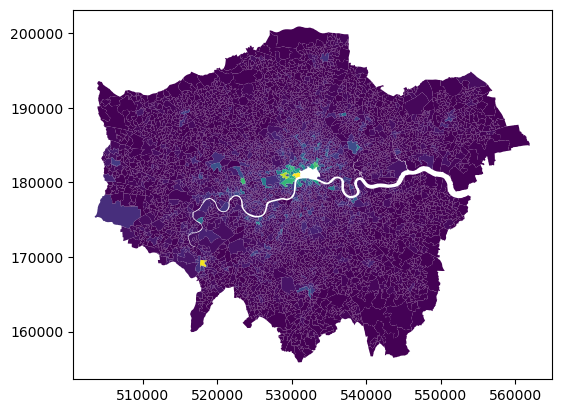

In [11]:
minor_dfs['BikeTheft'].plot('2011')

## Write to file

In [12]:
crime_opath = Path("../data/crime/")

In [13]:
for k, v in major_dfs.items():
    v.drop('geometry',axis=1, inplace=True)
    v.to_csv(crime_opath/"london-2011-2021-major-{0}.csv".format(k),index=False)

In [14]:
for k, v in minor_dfs.items():
    v.drop('geometry',axis=1, inplace=True)
    v.to_csv(crime_opath/"london-2011-2021-minor-{0}.csv".format(k),index=False)